## Import des librairies

In [71]:
import numpy as np
import pandas as pd
from pprint import pprint

#Scraping des Tweets
import twint 
import nest_asyncio

#Preprocessing
from unidecode import unidecode
import re,string
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer


#Dataviz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from yellowbrick.cluster import InterclusterDistance

#Vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Modèles de classification SKLearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

#Modèles de classification Gensim
import gensim,  logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.nmf import Nmf
from operator import itemgetter
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

#Logs d'erreurs
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#Plots de progression
from tqdm import tqdm 

In [2]:
nest_asyncio.apply()

# 1.<span style="color:red"> EXTRACTION & COLLECTE DES TWEETS </span>

In [3]:
# Configuration 
#c = twint.Config()
#c.Search ="europeansuperleague OR superleague européene"  #Topic de recherche
#c.Lang = "fr" #langue des Tweets
#c.Store_csv = True #Type de storage
#c.Output = "data/ESL.CSV" #Adresse du storage
#c.Pandas= True #conversion vers df
#c.Since = "2021-04-18" #date de début
#twint.run.Search(c) 

In [74]:
df = pd.read_csv("data/super_league_europeenne16.csv")
df = df.loc[df['language'] == "fr"]
df = df.loc[:, ['date', 'time','tweet', 'likes_count','retweets_count']]
df = df.drop_duplicates(subset='tweet', keep="first") #Suppression des doublons

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2444
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            2400 non-null   object
 1   time            2400 non-null   object
 2   tweet           2400 non-null   object
 3   likes_count     2400 non-null   int64 
 4   retweets_count  2400 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 112.5+ KB


In [76]:
df['date'].describe(datetime_is_numeric=True).to_frame()

,date
count,2400
unique,53
top,2021-04-19
freq,1029


In [77]:
df.isna().sum()

date              0
time              0
tweet             0
likes_count       0
retweets_count    0
dtype: int64

In [78]:
df.sample(10)

,date,time,tweet,likes_count,retweets_count
767,2021-04-20,00:26:24,Les clubs qui proposent la #SuperLeague n'ont pas dit de mettre fin à la champions League Européenne mais ils vont plutôt concurrencer l'instance ...,0,0
2041,2021-04-18,19:02:33,"@hpenot_lequipe Par contre, Hervé certains se disaient être contre la VAR car ce serait la mort soit disant du football. Est-ce que tes confrères ...",0,0
2080,2021-04-18,18:16:57,"@bayoko_youssouf @kakarot________ @BlaugranaAtlas C'est le bal des hypocrites, pire qu'à Koh Lanta. Si cette « Super League » européenne voit le j...",1,0
1505,2021-04-19,08:27:33,Super Ligue : la FIFA « ne peut que désapprouver une Ligue européenne fermée et dissidente » https://t.co/AeMsCxouS8 #SuperLeague https://t.co/o...,0,0
1381,2021-04-19,10:10:09,JP Morgan Chase est une garantie supplémentaire de la future super league européenne,1,0
2180,2021-04-18,16:56:03,☎️Déclaration officielle de l'UEFA à propos de la Super League: «Les clubs concernés seront interdits de jouer dans toute autre compétition nation...,76,13
680,2021-04-20,10:36:55,"La super league Européenne, ça sent l’oseille …ça sent pas le foot. C’st comme un film où il y a tous les meilleurs acteurs du monde, y’a pas d’hi...",0,0
1396,2021-04-19,10:00:32,"""Le PSG et le Qatar tuent le football européen "" Florentino Perez crée une super league européenne avec 12 autres club et la sa bégaye 👏👏",2,0
1766,2021-04-19,00:20:15,"Si la Super League échoue, le Real Madrid ne participera JAMAIS à aucune compétition européenne tant que Florentino Perez en sera le président.@Te...",27,1
2334,2021-04-18,15:34:09,@MisterChicky @Hugo_fln Super League européenne,0,0


# 2. <span style="color:blue">  PREPROCESSING</span>

### 2.1 <span style="color:black">  ANALYSE DESCRIPTIVE</span>

In [79]:
pd.options.display.max_colwidth = 150

In [80]:
#Conversion de la colonne tweet en liste
twt_list=df['tweet'].tolist()
print(f"La liste est composée de {len(twt_list)} tweets")

La liste est composée de 2400 tweets


In [81]:
i = 2390

for twt in twt_list:
    if i <= len(twt_list):
        print(f"Le tweet {i} est de longueur : {len(twt)}")
    i+=1

Le tweet 2390 est de longueur : 303
Le tweet 2391 est de longueur : 308
Le tweet 2392 est de longueur : 216
Le tweet 2393 est de longueur : 282
Le tweet 2394 est de longueur : 233
Le tweet 2395 est de longueur : 293
Le tweet 2396 est de longueur : 258
Le tweet 2397 est de longueur : 284
Le tweet 2398 est de longueur : 287
Le tweet 2399 est de longueur : 262
Le tweet 2400 est de longueur : 257


In [82]:
i = 2398

for twt in twt_list:
    liste_mots = twt.split() # Permet de séparer les mots d'une chaines de caractère en fonction d'un séparateur 
                             # par défault l'espace.
    if i <= len(twt_list):    
        print(f"Le tweet {i} contient {len(liste_mots)} mots")
        print(f"La liste de mots du tweet {i} : {liste_mots} \n")
        i+=1

Le tweet 2398 contient 43 mots
La liste de mots du tweet 2398 : ['⚽️🇪🇺', '«', "J'espère", 'que', 'cet', '#Euro2020', 'joué', 'dans', '11', 'pays', 'différents', 'à', "l'orée", 'de', 'la', 'présidence', '🇫🇷', 'de', "l'UE", 'par', '@EmmanuelMacron', 'créera', 'une', 'dynamique', 'pour', 'une', 'politique', 'sportive', 'européenne', '!', 'La', '#SuperLeague', 'est', 'un', 'avertissement,', 'réagissons', 'pour', 'protéger', 'nos', 'championnats', 'domestiques.', '»', 'https://t.co/6pEKlZA6f7'] 

Le tweet 2399 contient 51 mots
La liste de mots du tweet 2399 : ['@TalkMyFootball', '@Az21552916', 'Non', 'mais', 'le', 'problème', 'est', 'de', 'diviser', 'le', 'championnat', 'en', 'lots.', 'Dans', "l'affaire", 'de', 'la', 'super', 'league', 'européenne,', 'le', 'président', 'du', 'Real', 'parlait', 'du', 'désintérêt', 'grandissant', 'des', 'jeunes', 'pour', 'le', 'foot..', 'Bah', 'ouais,', 'quand', 'tu', 'es', 'jeune,', 'tu', 'as', 'beaucoup', 'de', 'priorité', 'que', 'les', '40', 'abonnements',

In [83]:
#Les 10 tweets ayant sucités le plus de réactions
df.sort_values(['likes_count','retweets_count'],ascending = (False, False)).head(10)

,date,time,tweet,likes_count,retweets_count
1162,2021-04-19,13:22:13,"Des banderoles ont été affichées par les supporters des Reds devant Anfield. ""Honte sur vous"" ""RIP Liverpool, 1892-2021"" ""Les fans de Liverpool...",8778,1868
2246,2021-04-18,16:27:56,L’UEFA remercie les clubs français et les clubs allemands qui ont refusé de donner leur accord à la création de la Superleague Européenne.,8261,1050
1986,2021-04-18,20:09:19,"🔴 Sir Alex Ferguson dénonce le projet fermé d'une Superleague européenne : ""Parler d'une Super League, c'est s'éloigner de 70 ans du football euro...",8051,1313
2163,2021-04-18,17:05:35,"Emmanuel Macron ""salue la position des clubs français de refuser de participer à un projet de Superleague européenne de football menaçant le princ...",7146,720
1180,2021-04-19,13:05:25,"Toni Kroos, en novembre dernier : « Une SuperLeague européenne ? Nous ne sommes que des marionnettes de la FIFA et de l’UEFA. S’il y avait un syn...",4993,1114
990,2021-04-19,17:23:13,Le gouvernement espagnol ne soutient pas la création d'une Super League européenne. (Diario AS) https://t.co/8xvXDmMMBY,4375,467
933,2021-04-19,18:28:46,🔴 Le comité exécutif de l’UEFA discutera ce vendredi d’une possible exclusion des clubs impliqués dans la Super League Européenne. Les clubs conc...,2896,468
2410,2021-04-18,15:02:27,"🔴 Des clubs anglais, espagnols et italiens devraient officialiser dans les prochaines heures la création de la Superleague Européenne. Dans cette...",2757,374
1240,2021-04-19,11:57:03,"Arsène Wenger : ""La Super League, c'est une mauvaise idée. Le foot doit rester uni et basé sur le mérite sportif. Il doit également respecter l'hi...",2748,606
1006,2021-04-19,17:00:15,"🔴 L’UEFA songerait à expulser dès maintenant les équipes impliquées dans la Super League Européenne de ses compétitions. En #UCL, il ne resterait...",2483,553


### 2.2 <span style="color:black">  NETTOYAGE & TRANSFORMATION DE LA LISTE DES TWEETS</span>

#### <p style="text-align: left;">La liste des stopwords utilisée est celle de Spacy + Lettres</p>

In [84]:
stopWords = ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 
             'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 
             'aucun', 'aucune', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'auraient', 'aurait', 'auront', 'aussi', 
             'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 
             'avant', 'avec', 'avoir', 'avons', 'ayant', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'boum', 
             'bravo', 'brrr',"ça", "c'", 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 
             'celui', 'celui-ci', 'celui-là', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 'certes', 'ces', 
             'cet', 'cette', 'ceux', 'ceux-ci', 'ceux-là', 'chacun', 'chacune', 'chaque', 'cher', 'chers', 'chez', 'chiche', 'chut', 
             'chère', 'chères', 'ci', 'cinq', 'cinquantaine', 'cinquante', 'cinquantième', 'cinquième', 'clac', 'clic', 'combien', 
             'comme', 'comment', 'comparable', 'comparables', 'compris', 'concernant', 'contre', 'couic', 'crac', 'c’', "d'", 'da', 
             'dans', 'de', 'debout', 'dedans', 'dehors', 'deja', 'delà', 'depuis', 'dernier', 'derniere', 'derriere', 'derrière', 
             'des', 'desormais', 'desquelles', 'desquels', 'dessous', 'dessus', 'deux', 'deuxième', 'deuxièmement', 'devant', 'devers', 
             'devra', 'different', 'differentes', 'differents', 'différent', 'différente', 'différentes', 'différents', 'dire', 
             'directe', 'directement', 'dit', 'dite', 'dits', 'divers', 'diverse', 'diverses', 'dix', 'dix-huit', 'dix-neuf', 
             'dix-sept', 'dixième', 'doit', 'doivent', 'donc', 'dont', 'douze', 'douzième', 'dring', 'du', 'duquel', 'durant', 'dès', 
             'désormais', 'd’', 'effet', 'egale', 'egalement', 'egales', 'eh', 'elle', 'elle-même', 'elles', 'elles-mêmes', 'en', 
             'encore', 'enfin', 'entre', 'envers', 'environ', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'etc', 'etre', 
             'eu', 'euh', 'eux', 'eux-mêmes', 'exactement', 'excepté', 'extenso', 'exterieur', 'fais', 'faisaient', 'faisant', 'fait', 
             'façon', 'feront', 'fi', 'flac', 'floc', 'font', 'gens', 'ha', 'hein', 'hem', 'hep', 'hi', 'ho', 'holà', 'hop', 'hormis', 
             'hors', 'hou', 'houp', 'hue', 'hui', 'huit', 'huitième', 'hum', 'hurrah', 'hé', 'hélas', 'i', 'il', 'ils', 'importe', 
             "j'", 'je', 'jusqu', 'jusque', 'juste', 'j’', "l'", 'la', 'laisser', 'laquelle', 'las', 'le', 'lequel', 'les', 
             'lesquelles', 'lesquels', 'leur', 'leurs', 'longtemps', 'lors', 'lorsque', 'lui', 'lui-meme', 'lui-même', 'là', 'lès', 'l’', 
             "m'", 'ma', 'maint', 'maintenant', 'mais', 'malgre', 'malgré', 'maximale', 'me', 'meme', 'memes', 'merci', 'mes', 'mien', 'mienne', 
             'miennes', 'miens', 'mille', 'mince', 'minimale', 'moi', 'moi-meme', 'moi-même', 'moindres', 'moins', 'mon', 
             'moyennant', 'même', 'mêmes', 'm’', "n'", 'na', 'naturel', 'naturelle', 'naturelles', 'ne', 'neanmoins', 'necessaire', 
             'necessairement', 'neuf', 'neuvième', 'ni', 'nombreuses', 'nombreux', 'non', 'nos', 'notamment', 'notre', 'nous', 'nous-mêmes', 
             'nouveau', 'nul', 'néanmoins', 'nôtre', 'nôtres', 'n’', 'o', 'oh', 'ohé', 'ollé', 'olé', 'on', 'ont', 'onze', 'onzième', 'ore', 
             'ou', 'ouf', 'ouias', 'oust', 'ouste', 'outre', 'ouvert', 'ouverte', 'ouverts', 'où', 'paf', 'pan', 'par', 'parce', 'parfois', 
             'parle', 'parlent', 'parler', 'parmi', 'parseme', 'partant', 'particulier', 'particulière', 'particulièrement', 'pas', 'passé', 
             'pendant', 'pense', 'permet', 'personne', 'peu', 'peut', 'peuvent', 'peux', 'pff', 'pfft', 'pfut', 'pif', 'pire', 'plein', 'plouf', 
             'plus', 'plusieurs', 'plutôt', 'possessif', 'possessifs', 'possible', 'possibles', 'pouah', 'pour', 'pourquoi', 'pourrais', 'pourrait', 
             'pouvait', 'prealable', 'precisement', 'premier', 'première', 'premièrement', 'pres', 'probable', 'probante', 'procedant', 'proche', 
             'près', 'psitt', 'pu', 'puis', 'puisque', 'pur', 'pure', "qu'", 'quand', 'quant', 'quant-à-soi', 'quanta', 'quarante', 'quatorze', 
             'quatre', 'quatre-vingt', 'quatrième', 'quatrièmement', 'que', 'quel', 'quelconque', 'quelle', 'quelles', "quelqu'un", 'quelque', 
             'quelques', 'quels', 'qui', 'quiconque', 'quinze', 'quoi', 'quoique', 'qu’', 'rare', 'rarement', 'rares', 'relative', 'relativement', 
             'remarquable', 'rend', 'rendre', 'restant', 'reste', 'restent', 'restrictif', 'retour', 'revoici', 'revoilà', 'rien', "s'", 'sa', 
             'sacrebleu', 'sait', 'sans', 'sapristi', 'sauf', 'se', 'sein', 'seize', 'selon', 'semblable', 'semblaient', 'semble', 'semblent', 
             'sent', 'sept', 'septième', 'sera', 'seraient', 'serait', 'seront', 'ses', 'seul', 'seule', 'seulement', 'si', 'sien', 'sienne', 
             'siennes', 'siens', 'sinon', 'six', 'sixième', 'soi', 'soi-même', 'soit', 'soixante', 'son', 'sont', 'sous', 'souvent', 'specifique', 
             'specifiques', 'speculatif', 'stop', 'strictement', 'subtiles', 'suffisant', 'suffisante', 'suffit', 'suis', 'suit', 'suivant', 
             'suivante', 'suivantes', 'suivants', 'suivre', 'superpose', 'sur', 'surtout', 's’', "t'", 'ta', 'tac', 'tant', 'tardive', 'te', 
             'tel', 'telle', 'tellement', 'telles', 'tels', 'tenant', 'tend', 'tenir', 'tente', 'tes', 'tic', 'tien', 'tienne', 'tiennes', 
             'tiens', 'toc', 'toi', 'toi-même', 'ton', 'touchant', 'toujours', 'tous', 'tout', 'toute', 'toutefois', 'toutes', 'treize', 'trente', 
             'tres', 'trois', 'troisième', 'troisièmement', 'trop', 'très', 'tsoin', 'tsouin', 'tu', 'té', 't’', 'un', 'une', 'unes', 
             'uniformement', 'unique', 'uniques', 'uns', 'va', 'vais', 'vas', 'vers', 'via', 'vif', 'vifs', 'vingt', 'vivat', 'vive', 'vives', 
             'vlan', 'voici', 'voilà', 'vont', 'vos', 'votre', 'vous', 'vous-mêmes', 'vu', 'vé', 'vôtre', 'vôtres', 'zut', 'à', 'â', 'ça', 'ès', 
             'étaient', 'étais', 'était', 'étant', 'été', 'être', 'ô', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'qu','etes','à','quelqu']

stopWords = [unidecode(sw) for sw in stopWords]

#### <p style="text-align: left;">Définitions de fonctions de pré-processing</p>

In [85]:
#Fonction qui supprime les emojis avec un dict des emoticones 
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U0001F1F2-\U0001F1F4"  # Macau flag
                        u"\U0001F1E6-\U0001F1FF"  # flags
                        u"\U0001F600-\U0001F64F"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U0001F1F2"
                        u"\U0001F1F4"
                        u"\U0001F620"
                        u"\u200d"
                        u"\u2640-\u2642"
                       "]+", flags=re.UNICODE)  

def emoji(string):
    return emoji_pattern.sub(r'', string)

In [86]:
# Création du stemmer
stemmer = FrenchStemmer()

In [87]:
def stemmatise_text(text, stemmer):

    return " ".join([stemmer.stem(word) for word in text.split()])


In [88]:
def df_cleaner(pandasSeries, stopWords):
    
    print("#### Nettoyage en cours ####") 
    
    # confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
    
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())
    
    #Suppression de la ponctuation
    print("... Suppression de la ponctuation")
    pandasSeries = pandasSeries.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
    
    #Suppression des unicodes
    print("... Suppression des unicodes")
    pandasSeries = pandasSeries.apply(lambda x: re.sub('[«»]', '', x))
    
                                       
    # Suppression des urls
    print("... Suppression des urls") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"http\S+", '', x))
    
    # Suppression des emojis
    print("... Suppression des emojis") 
    pandasSeries = pandasSeries.apply(emoji)
    
    # Suppression des stop words
    print("... Suppression des stop words") 
    pandasSeries = pandasSeries.apply(lambda x:' '.join([word for word in x.split() if word not in stopWords]))
    pandasSeries = pandasSeries.apply(lambda x: re.sub('[àç]', '', x))
    
    # Stemmatisation
    #print("... Stemmatisation") 
    #pandasSeries = pandasSeries.apply(lambda x : stemmatise_text(x, stemmer))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries

#### <p style="text-align: left;">Application des fonctions de pre-processing sur la colonne `tweet` et stockage du résultat dans la colonne `tweet_clean`</p>

In [89]:
%%time 
df['tweet_clean'] = df_cleaner(df['tweet'], stopWords)

df[['tweet', 'tweet_clean']].sample(10)

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression de la ponctuation
... Suppression des unicodes
... Suppression des urls
... Suppression des emojis
... Suppression des stop words
#### Nettoyage OK! ####
Wall time: 464 ms


,tweet,tweet_clean
262,"Super League européenne: Man United, Liverpool, Chelsea, Spurs, Arsenal, Inter Milan et Man City abandonnent tous #Liverpool, entre autres, a qui...",super league européenne man united liverpool chelsea spurs arsenal inter milan man city abandonnent liverpool quitté projet super league européenn...
657,"A Florentino Pérez président du Réal Madrid : Les Amoureux du Football doivent BOYCOTTER ""LA SUPER LEAGUE EUROPEENNE"" ! - Signez la pétition ! ht...",florentino pérez président réal madrid amoureux football boycotter super league europeenne signez pétition changefrance
1860,"Ils sont 12. 12 clubs a faire face à l’UEFA. Le Real Madrid, le FC Barcelone, l’Atlético, l’Inter, l’AC Milan, la Juventus, Manchester City, Manch...",12 12 clubs faire face l’uefa real madrid fc barcelone l’atlético l’inter l’ac milan juventus manchester city manchester united arsenal liverpool...
1771,Si le PSG va à la Super League Européenne ils pourront affronter le Vinsky FC??,psg super league européenne pourront affronter vinsky fc
1714,"Si la Super League échoue, le Real Madrid ne participera JAMAIS à aucune compétition européenne tant que Florentino Perez en sera le président. [ ...",super league échoue real madrid participera jamais compétition européenne florentino perez président dailymail
2145,TOUT COMPRENDRE - La guerre entre l'UEFA et le projet de Superleague européenne https://t.co/Zo1awkSeI8 via @RMCsport,comprendre guerre luefa projet superleague européenne rmcsport
372,"Liverpool a interrompu ses plans de rejoindre la Super League européenne . La pression des fans ,médias anglais et puis les joueurs ont donné un e...",liverpool interrompu plans rejoindre super league européenne pression fans médias anglais joueurs donné immédiat propriétaires liverpool
2117,"La super League européenne ? Quel est l’interêt sérieusement ???? J’arrive pas à comprendre, je vois pas l’utilité, rien ne vaut la LDC et l’UEL 🤷...",super league européenne l’interêt sérieusement j’arrive comprendre vois l’utilité vaut ldc l’uel
777,"Les joueurs participant ne seront pas suspendu de compétition européenne, cela n’arrivera pas » #SuperLeague",joueurs participant suspendu compétition européenne n’arrivera superleague
2214,Les 12 clubs qui veulent créer la SuperLeague sortent de la LDC. C’est leur volonté pour jouer cette nouvelle compétition européenne sans que l’UE...,12 clubs veulent créer superleague sortent ldc c’est volonté jouer nouvelle compétition européenne l’uefa prenne l’argent l’uefa ligues nationales...


# 3. <span style="color:GREEN">  DATA VIZ </span>

### 3.1 <span style="color:black">  Nombre de mots </span>

In [90]:
df1 = (df['tweet_clean'].str.split(expand=True).stack().value_counts().rename_axis('mots').reset_index(name='Occurrences')).set_index('mots')
df1.head(21)

,Occurrences
mots,
européenne,2360
league,1645
super,1612
superleague,1074
clubs,733
football,447
projet,340
compétition,261
ligue,242


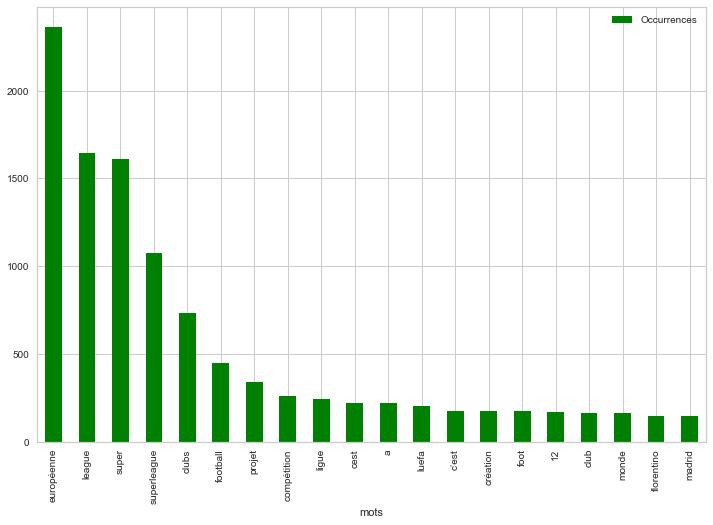

In [91]:
df1.head(20).plot(kind = "bar", figsize=(12, 8), color = "Green");

### 3.2 <span style="color:black"> Bigrams & Trigrams</span>

In [92]:
corpus = df['tweet_clean'].str.split()

In [93]:
# bigrammes dans un document
print(f"Notre document n° 99: {corpus[99]} \n")


print(f"La liste des bigrammes présents dans le document n°99 : {list(nltk.bigrams(corpus[99]))}")
print("")
print(f"La liste des Trigrammes présents dans le document n°99 : {list(nltk.trigrams(corpus[99]))}")

Notre document n° 99: ['officiel', '12', 'clubs', 'super', 'league', 'européenne', 'manutd', 'don', 'collectif', '15', 'millions', 'deuros', 'bonnes', 'causes', 'perdront', '5', 'recettes', 'compétitions', 'luefa', 'saison', 'prochaine', 'dinterdiction', 'compétition', 'mufc'] 

La liste des bigrammes présents dans le document n°99 : [('officiel', '12'), ('12', 'clubs'), ('clubs', 'super'), ('super', 'league'), ('league', 'européenne'), ('européenne', 'manutd'), ('manutd', 'don'), ('don', 'collectif'), ('collectif', '15'), ('15', 'millions'), ('millions', 'deuros'), ('deuros', 'bonnes'), ('bonnes', 'causes'), ('causes', 'perdront'), ('perdront', '5'), ('5', 'recettes'), ('recettes', 'compétitions'), ('compétitions', 'luefa'), ('luefa', 'saison'), ('saison', 'prochaine'), ('prochaine', 'dinterdiction'), ('dinterdiction', 'compétition'), ('compétition', 'mufc')]

La liste des Trigrammes présents dans le document n°99 : [('officiel', '12', 'clubs'), ('12', 'clubs', 'super'), ('clubs', 'su

### 3.3 <span style="color:black"> Nuages de mots </span>

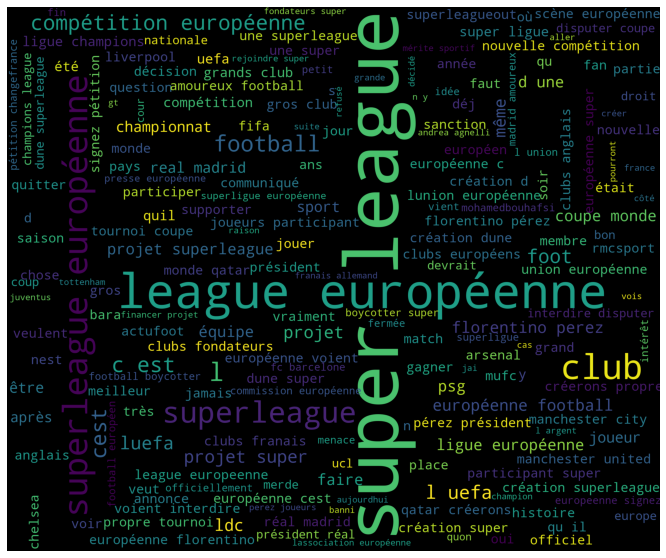

In [94]:
wordcloud = WordCloud(width = 1200,height = 1000,scale = 2, background_color='black',collocations=True).generate(' '.join(df["tweet_clean"]))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# 4. <span style="color:Orange">  Classification non supervisée </span>

[![Unsupervised.png](https://i.postimg.cc/TYBv1nJ3/Unsupervised.png)](https://postimg.cc/svPN0QLk)

**Clustering**  : c'est une méthode de regroupement des objets en groupes de telle sorte que ceux qui présentent le plus de similitudes restent dans un groupe et présentent moins ou pas de similitudes avec les objets d'un autre groupe. L'analyse de cluster trouve les points communs entre les objets de données et les catégorise selon la présence et l'absence de ces points communs.

**Association**: Une règle d'association est une méthode d'apprentissage non supervisée qui est utilisée pour trouver les relations entre les variables dans une base de données. Il détermine l'ensemble des éléments qui se produisent ensemble dans l'ensemble de données. La règle d'association peut rendre une stratégie marketing plus efficace. Comme les personnes qui achètent un article X (supposons un pain) ont également tendance à acheter un article Y (beurre/confiture). Un exemple typique de règle d'association est l'analyse du panier de marché.

[![Scikit-learn-logo-small.png](https://i.postimg.cc/xTGTfcqV/Scikit-learn-logo-small.png)](https://postimg.cc/ykdzn6FL)

### 4.1 <span style="color:black">  K-means Clustering</span>

####  4.1.1 <span style="color:black">  TF-IDF</span>

Le ratio TF-IDF (Term-Frequency - Inverse Document Frequency) permet de pondérer la fréquence des tokens (mots dans notre corpus) dans un document par son importance relative dans les autres documents.

Ce score tient donc compte de la composition de notre corpus.

In [95]:
#Vectorisation des bigram et avec un minimum d'apparitions de 2 fois
vectorizer = TfidfVectorizer(ngram_range=range(1,3), min_df=2,stop_words=stopWords)
X = vectorizer.fit_transform(df['tweet_clean'])

print(X.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [96]:
pd.DataFrame(vectorizer.get_feature_names()).sample(10)

,0
4540,rejeté
4722,récompense
4060,plainte
815,city annonce
49,1ère
5634,érigé porteur
398,arsenal inter
2211,financière
138,accrocher place
1921,européenne riches


####  4.1.2 <span style="color:black">  Choix du nombre de clusters `true_k` avec la méthode "elbow"</span>

Le choix du true_k se fera graphiquement en prenant l'abcisse du coude correspondant à une faible pente du graph.

In [ ]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.grid(True)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

####  4.1.3 <span style="color:black">  Application de l'algorithme K-means</span>

In [97]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++')
model.fit(X)

print("Top termes par cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % (terms[ind])),
    print

print("\n")

Top termes par cluster:
Cluster 0:
 ligue
 ligue européenne
 ligue champions
 super ligue
 champions
 superleague
 européenne
 super
 fermée
 projet
Cluster 1:
 coupe monde
 coupe
 monde
 propre
 2022
 monde 2022
 créerons
 créerons propre
 tournoi coupe
 2022 qatar
Cluster 2:
 league
 super league
 super
 league européenne
 européenne
 clubs
 football
 projet
 projet super
 compétition
Cluster 3:
 superleague
 superleague européenne
 européenne
 clubs
 projet
 compétition
 football
 cest
 projet superleague
 uefa
Cluster 4:
 européenne football
 heineken
 humour
 heineken trolle
 trolle
 football humour
 football
 échec
 trolle échec
 échec super




####  4.1.4 <span style="color:black">  Test de prédiction du cluster</span>

In [98]:
print("\n")
print("Prediction")
X = vectorizer.transform(["qui est la banque qui finance ce projet"])
predicted = model.predict(X)
print(predicted)



Prediction
[3]


####  4.1.5 <span style="color:black">  Visualisation de la distance interclusters</span>

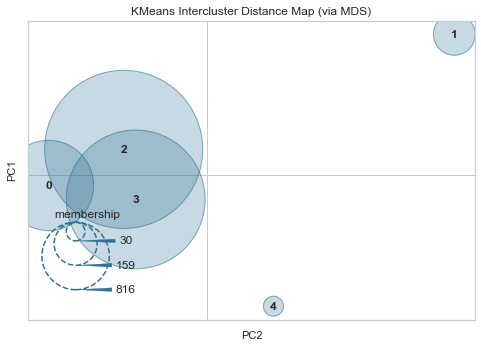

In [100]:
visualizer = InterclusterDistance(model)
visualizer.fit(X)
visualizer.show();

### 4.2 <span style="color:black">  Topic Modelling (LatentDirichletAllocation)</span>

####  4.2.1 <span style="color:black">  Vectorisation & Transformation </span>

In [31]:
#Filtre appliqué sur les mots qui apparaissent dans moins de 10% des tweets 
vectorizer = CountVectorizer(min_df=25, token_pattern=r'\w+|\$[\d\.]+|\S+n')

In [32]:
tf = vectorizer.fit_transform(df['tweet_clean']).toarray()

In [33]:
tf_feature_names = vectorizer.get_feature_names()

####  4.2.2 <span style="color:black">  Modélisation </span>

In [34]:
#Choix de nombre de topics arbitraire
number_of_topics = 6

model2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model2.fit(tf)

LatentDirichletAllocation(n_components=6, random_state=0)

In [35]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [36]:
no_top_words = 10
display_topics(model2, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,monde,161.2,league,959.2,l,394.3,superleague,532.7,clubs,572.7,league,399.2
1,joueurs,126.6,super,951.6,d,252.2,européenne,478.2,européenne,469.9,européenne,387.1
2,coupe,121.2,européenne,727.6,européenne,243.9,a,185.6,superleague,297.3,super,383.3
3,perez,59.9,football,183.5,superleague,194.0,est,159.0,league,204.3,projet,132.0
4,européenne,56.3,président,98.9,uefa,191.9,c,152.0,super,190.3,manchester,96.2
5,florentino,53.6,florentino,87.8,’un,109.2,football,140.5,luefa,178.4,football,90.4
6,participant,50.2,foot,73.6,e,101.2,l,95.5,12,169.1,city,73.2
7,super,49.0,projet,72.7,être,86.6,foot,90.7,ligue,153.1,liverpool,72.6
8,league,47.9,perez,67.5,clubs,79.7,cest,78.4,compétition,145.3,club,70.8
9,propre,41.2,madrid,65.1,s,78.2,projet,69.1,champions,95.2,chelsea,65.2


Sans trop de surprises, les termes ayant le plus de poids (occurences) dans les tweets sont :
- super league européenne
- UEFA / FIFA
- 12 clubs fondateurs de l'ESL
- Florentino Perez le président du Réal Madrid par celui l'annonce est venue
- PSG / Real / Manchester U/ Manchester City/ Arsenal / Milan : qui sont les clubs protagonistes ou antagonistes du projet

### 4.3 <span style="color:black">  Topic Modelling (Non-Negative Matrix Factorization)</span>

####  4.3.1 <span style="color:black">  Vectorisation & Transformation </span>

In [37]:
D = TfidfVectorizer(min_df=25, stop_words=stopWords)
# Fit and transform
F = D.fit_transform(df.tweet_clean)

####  4.3.2 <span style="color:black">  Modélisation </span>

In [38]:
model3 = NMF(n_components=6, random_state=5, init='nndsvda')
model3.fit(F)
nmf_features = model3.transform(F)

In [39]:
components_df = pd.DataFrame(model3.components_, columns=D.get_feature_names())

####  4.3.3 <span style="color:black"> Top5 des Topics obtenus </span>

In [112]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'les mots les plus récurrents du topic {topic} :')
    print(tmp.nlargest(5))
    print('\n')

les mots les plus récurrents du topic 0 :
league        3.268756
super         3.194360
européenne    2.088284
création      0.182322
foot          0.167735
Name: 0, dtype: float64


les mots les plus récurrents du topic 1 :
superleague    3.016324
européenne     1.511765
ligue          0.191479
compétition    0.190178
cest           0.178855
Name: 1, dtype: float64


les mots les plus récurrents du topic 2 :
clubs          2.497761
12             0.849688
compétition    0.610498
uefa           0.539847
luefa          0.531238
Name: 2, dtype: float64


les mots les plus récurrents du topic 3 :
football    3.001833
sport       0.204888
européen    0.179807
uefa        0.174382
être        0.151709
Name: 3, dtype: float64


les mots les plus récurrents du topic 4 :
projet    2.612914
foot      0.766825
ligue     0.351840
banque    0.265851
luefa     0.206072
Name: 4, dtype: float64


les mots les plus récurrents du topic 5 :
florentino    1.320555
perez         1.187916
monde         0.8

####  4.3.3 <span style="color:black">  Visualisation des Topics obtenus </span>

[![1-xbe-Uz-Ef-XA5tnd-W9z-M4g-Or-Q.png](https://i.postimg.cc/XqkSbBL2/1-xbe-Uz-Ef-XA5tnd-W9z-M4g-Or-Q.png)](https://postimg.cc/tnJmdTLP)

### 4.4 <span style="color:black">  Topic Modelling (LDA) </span>

    -Conversion en liste

In [42]:
#Conversion en liste
tweet_list = df['tweet_clean'].to_list()

    -Création des bigram & Trigram

In [43]:
bigram = gensim.models.Phrases(tweet_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_list], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

    -Reprocessing : Lemmatisation / Tokenisation & Suppression des stop words

In [44]:
def process_words(texts, stop_words=stopWords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [45]:
tweet_ready = process_words([tweet_list])  # Liste des tweets

In [46]:
tweet_dict = corpora.Dictionary(tweet_ready)

#tweet_dict.filter_extremes(no_below=2, no_above=.99) #Filtre pour les valeurs extrêmes

# Creation du corpus
corpus = [tweet_dict.doc2bow(text) for text in tweet_ready]

# Build LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweet_dict,
                                           num_topics=10, 
                                           random_state=100)


pprint(ldamodel.print_topics())

[(0,
  '0.070*"européen" + 0.053*"super" + 0.044*"leagu" + 0.029*"superleagu" + '
  '0.025*"club" + 0.014*"league" + 0.014*"football" + 0.012*"projet" + '
  '0.010*"compétition" + 0.007*"luefer"'),
 (1,
  '0.060*"européen" + 0.043*"super" + 0.027*"leagu" + 0.026*"superleagu" + '
  '0.020*"club" + 0.012*"football" + 0.010*"projet" + 0.009*"league" + '
  '0.007*"compétition" + 0.005*"joueur"'),
 (2,
  '0.043*"européen" + 0.030*"super" + 0.024*"leagu" + 0.022*"club" + '
  '0.020*"superleagu" + 0.011*"football" + 0.007*"compétition" + '
  '0.006*"projet" + 0.006*"league" + 0.005*"florentino"'),
 (3,
  '0.059*"européen" + 0.047*"super" + 0.028*"club" + 0.028*"superleagu" + '
  '0.023*"leagu" + 0.014*"football" + 0.012*"league" + 0.010*"projet" + '
  '0.007*"compétition" + 0.005*"foot"'),
 (4,
  '0.065*"européen" + 0.029*"super" + 0.026*"leagu" + 0.023*"superleagu" + '
  '0.023*"club" + 0.013*"football" + 0.009*"projet" + 0.008*"league" + '
  '0.008*"compétition" + 0.006*"création"'),
 (5,
 

#### 4.4.1 Cohérance & Perplexité

- Cohérance : Les mesures de cohérence des topics évaluent un seul Topic en mesurant le degré de similitude sémantique entre les mots à score élevé dans ce même topic. Ces mesures permettent de distinguer les topics qui sont sémantiquement interprétables des autres topics qui sont des artefacts d'inférence statistique.

 - Perplexité: est une mesure statistique de la capacité d'un modèle de probabilité à prédire un échantillon.

In [47]:
base_perplexity = ldamodel.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamodel, texts=tweet_ready, 
                                   dictionary=tweet_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.759597849137938

Coherence Score:  0.254223403657525


#### 4.4.2 Tunning des hyperparamètres du modèle

- #### 4.4.2.1 Perplexité

 - Remarque : Une perplexité négative est principalement dûe au log_perplexity qui génère le log de la probabilité

 -  Plus la perplexité est elevée plus le modèle prédit mieux.

In [48]:
def plot_perplexity(dict_, corpus):
    num_topics_range = range(2, 20)
    perplexities = []
    for num_topics in num_topics_range:
        lda_model = ldamodel
        perplexities.append(lda_model.log_perplexity(corpus))
    plt.plot(num_topics_range, perplexities, color='blue', marker='o', markersize=5)
    plt.title('Log perplexité en fonction des nombres des topics')
    plt.xlabel('Nombre de topics')
    plt.ylabel('Log perplexité')
    plt.grid()
    plt.show()

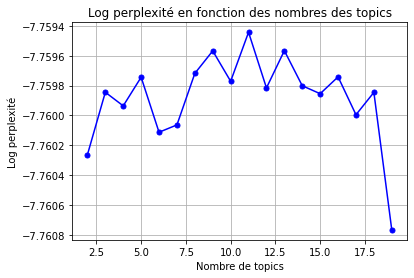

In [49]:
number_topics = 20
plot_perplexity(tweet_dict, corpus)

- #### 4.4.2.2 Cohérance

 - La cohérance varie généralement de 0.3 (bas) --> 0.6(bon) --> 0.9 ~ 1 (faux)
 - La cohérance peutêtre améliorée par le choix des topics, le changement des coefficients alpha ou beta

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    ldamodel = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=tweet_ready, dictionary=tweet_dict, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

- Résultat du tunning:

In [51]:
df_result=pd.read_csv('lda_tuning_results.csv')

In [52]:
df_result.sort_values(["Coherence"], axis=0, ascending=False, inplace=True) 
df_result.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
388,100% Corpus,5,asymmetric,0.9099999999999999,0.502472
533,100% Corpus,10,symmetric,0.9099999999999999,0.500089
513,100% Corpus,10,0.01,0.9099999999999999,0.488323
488,100% Corpus,9,0.31,0.9099999999999999,0.487897
298,100% Corpus,2,asymmetric,0.9099999999999999,0.486332
518,100% Corpus,10,0.31,0.9099999999999999,0.477772
487,100% Corpus,9,0.31,0.61,0.473631
417,100% Corpus,6,asymmetric,0.61,0.472196
477,100% Corpus,8,asymmetric,0.61,0.466220
58,75% Corpus,3,asymmetric,0.9099999999999999,0.463794


- #### 4.4.2.3 Modèle amélioré

In [53]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=tweet_dict,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           eta=0.9)


pprint(ldamodel.print_topics()) 

[(0,
  '0.069*"européen" + 0.044*"super" + 0.033*"leagu" + 0.027*"superleagu" + '
  '0.025*"club" + 0.012*"football" + 0.012*"league" + 0.010*"projet" + '
  '0.008*"compétition" + 0.006*"luefer"'),
 (1,
  '0.000*"européen" + 0.000*"super" + 0.000*"superleagu" + 0.000*"leagu" + '
  '0.000*"club" + 0.000*"football" + 0.000*"projet" + 0.000*"league" + '
  '0.000*"compétition" + 0.000*"joueur"'),
 (2,
  '0.000*"européen" + 0.000*"super" + 0.000*"leagu" + 0.000*"club" + '
  '0.000*"superleagu" + 0.000*"football" + 0.000*"compétition" + '
  '0.000*"projet" + 0.000*"league" + 0.000*"florentino"'),
 (3,
  '0.000*"européen" + 0.000*"super" + 0.000*"club" + 0.000*"superleagu" + '
  '0.000*"leagu" + 0.000*"football" + 0.000*"league" + 0.000*"projet" + '
  '0.000*"compétition" + 0.000*"foot"'),
 (4,
  '0.000*"européen" + 0.000*"super" + 0.000*"leagu" + 0.000*"club" + '
  '0.000*"superleagu" + 0.000*"football" + 0.000*"projet" + 0.000*"league" + '
  '0.000*"compétition" + 0.000*"création"'),
 (5,
 

In [54]:
base_perplexity = ldamodel.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamodel, texts=tweet_ready, 
                                   dictionary=tweet_dict, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -6.839897985596538

Coherence Score:  0.2566524935045284


- #### 4.4.2.4 Visualisation des topics obtenus

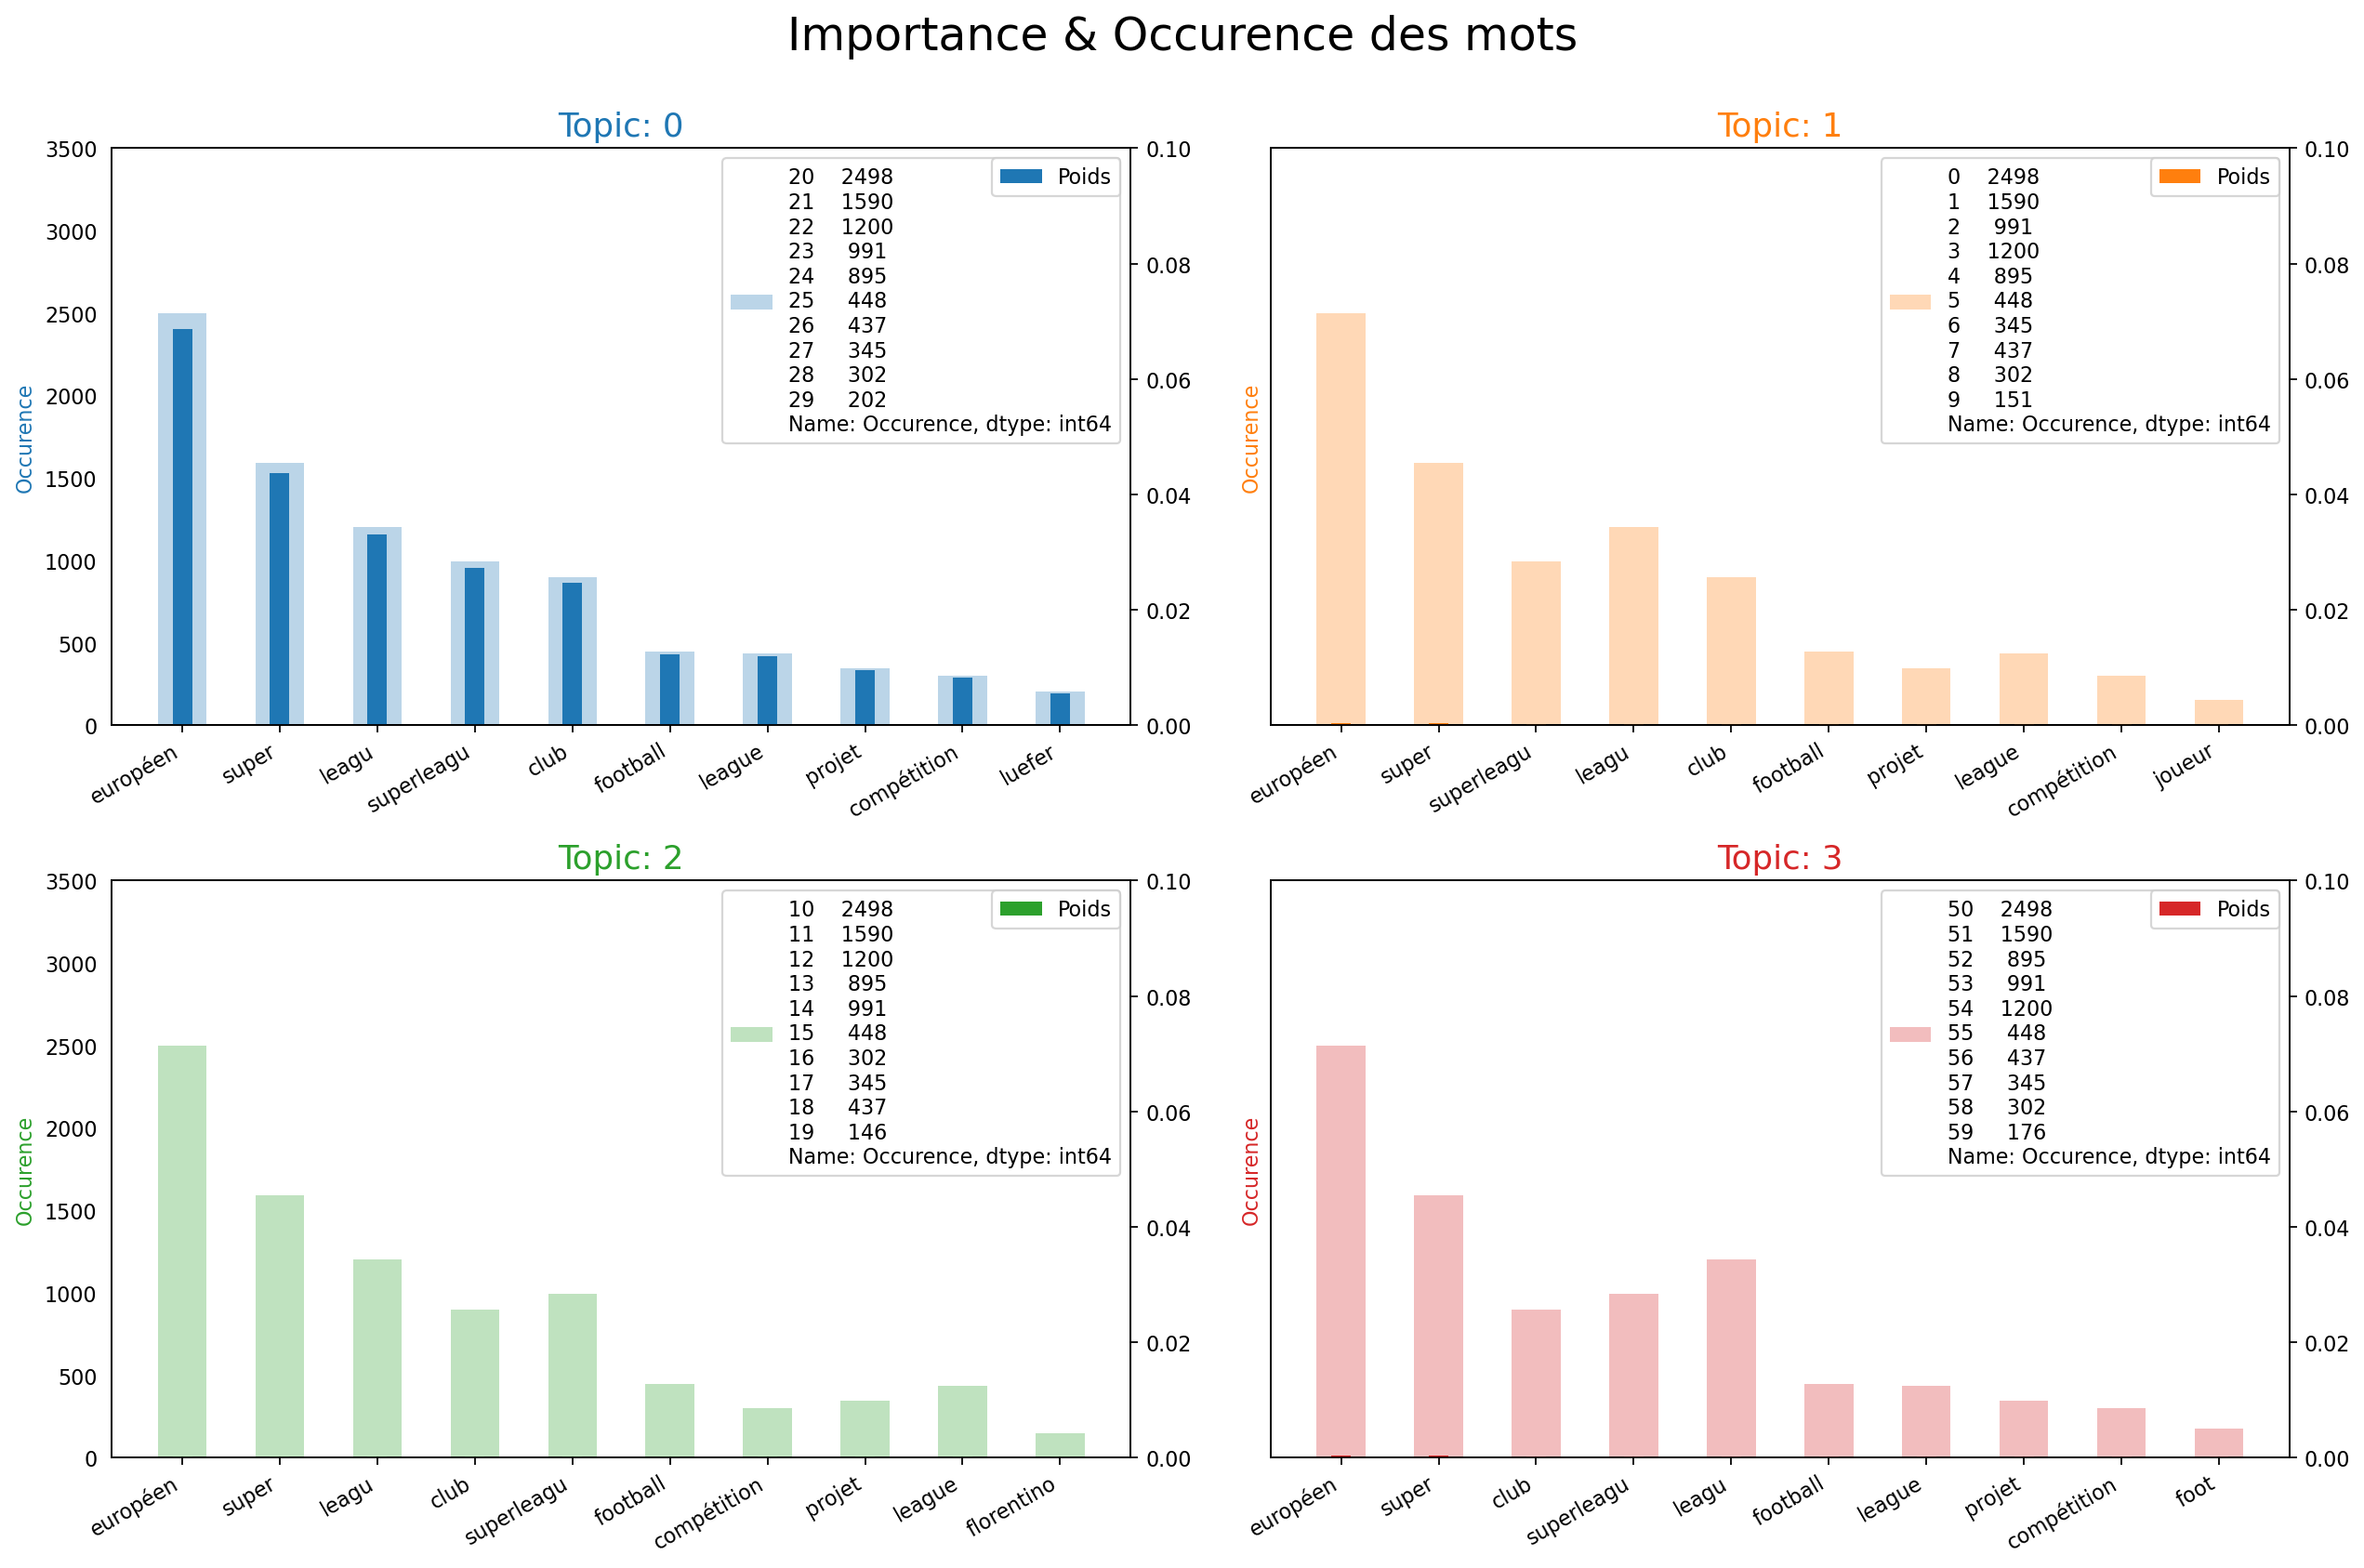

In [55]:
topics = ldamodel.show_topics(formatted=False)
data_flat = [w for w_list in tweet_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['Mot', 'topic_id', 'importance', 'Occurence'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Mot', height="Occurence", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Occurence')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Mot', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Poids')
    ax.set_ylabel('Occurence', color=cols[i])
    ax_twin.set_ylim(0, 0.100); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticks(df.loc[df.topic_id==i, 'Mot'])
    ax.set_xticklabels(df.loc[df.topic_id==i, 'Mot'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='best'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)    
fig.suptitle('Importance & Occurence des mots', fontsize=22, y=1.05)    
plt.show()

In [57]:
pyLDAvis.enable_notebook()
gensim_dictionary = tweet_dict
gensim_corpus = corpus
lda_model = ldamodel


lda_visualization = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

C:\Users\eloue\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


### 4.5 <span style="color:black">  Topic Modelling (NMF) </span>

In [58]:
dictionary = Dictionary(tweet_ready)

corpus = [dictionary.doc2bow(text) for text in tweet_ready]

- Création du bag of words avec un format : (list of(token_id, token_count))

In [59]:
corpus = [dictionary.doc2bow(text) for text in tweet_ready]

In [60]:
nmf = Nmf(
    corpus=corpus,
    num_topics=10,
    id2word=dictionary,
    chunksize=1000,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=0,
    kappa=1,
)
pprint(nmf.print_topics())

[(0,
  '0.072*"européen" + 0.046*"super" + 0.035*"leagu" + 0.029*"superleagu" + '
  '0.026*"club" + 0.013*"football" + 0.013*"league" + 0.010*"projet" + '
  '0.009*"compétition" + 0.006*"luefer"'),
 (1,
  '0.081*"européen" + 0.051*"super" + 0.039*"leagu" + 0.032*"superleagu" + '
  '0.029*"club" + 0.014*"football" + 0.014*"league" + 0.011*"projet" + '
  '0.010*"compétition" + 0.007*"luefer"'),
 (2,
  '0.070*"européen" + 0.045*"super" + 0.034*"leagu" + 0.028*"superleagu" + '
  '0.025*"club" + 0.013*"football" + 0.012*"league" + 0.010*"projet" + '
  '0.008*"compétition" + 0.006*"luefer"'),
 (3,
  '0.001*"lespace" + 0.001*"relance" + 0.001*"division" + 0.001*"pathétique" + '
  '0.001*"quatar" + 0.001*"tslcomms" + 0.001*"nenterr" + 0.001*"barca" + '
  '0.001*"diriger" + 0.001*"saintgermain"'),
 (4,
  '0.075*"européen" + 0.048*"super" + 0.036*"leagu" + 0.030*"superleagu" + '
  '0.027*"club" + 0.013*"football" + 0.013*"league" + 0.010*"projet" + '
  '0.009*"compétition" + 0.006*"luefer"'),
 (

- #### 4.5.1 Cohérance

In [61]:
coherence_model_nmf = CoherenceModel(
        model=nmf,
        texts=tweet_ready,
        dictionary=dictionary,
        coherence='c_v')
    
coherence_nmf = coherence_model_nmf.get_coherence()
print('\nCoherence Score: ', coherence_nmf)


Coherence Score:  0.41645799257138566


- #### 4.5.2 Visualisation des topics obtenus